In [1]:
import IntelligentPlacer
from IntelligentPlacer.image_processing import find_bboxes, delete_spots, find_edges, draw_bbox, get_binary_image

from IntelligentPlacer.placer import find_min_intersection_configuration

from IntelligentPlacer.classification import ObjectsRecognizer

from imageio import imread
from skimage.color import rgb2gray
from matplotlib import pyplot as plt
import numpy as np

2022-04-08 15:43:17.023542: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nadia/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-04-08 15:43:17.023567: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Сначала алгоритм ищет bounding box для каждого объекта 

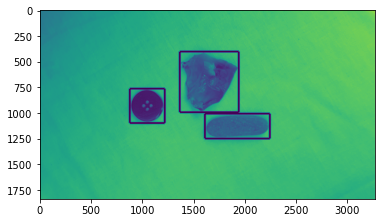

In [2]:
img = imread("../data/IMGS/IMG_41.jpg" )
if img.shape[0] > img.shape[1]:
    img = np.flip(np.transpose(img, axes=(1, 0, 2)), axis=1)
    
gray_img = rgb2gray(img)
bboxes = find_bboxes(gray_img)
with_bboxes = gray_img.copy()
for b in bboxes:
    draw_bbox(with_bboxes, b)    

plt.imshow(with_bboxes);

#### Далее, используя алгоритм нахождения bounding box,  находми маски предметов. 

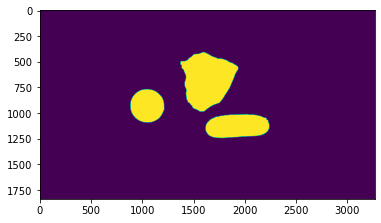

In [3]:
binary_img = delete_spots(get_binary_image(gray_img))
plt.imshow(binary_img);

#### Далее с помощью масок выделяем объекты и обрабатываем их, чтобы затем классифицировать

In [4]:
objr = ObjectsRecognizer("./IntelligentPlacer")

2022-04-08 15:43:50.720334: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nadia/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-04-08 15:43:50.720365: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-08 15:43:50.720394: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Beemo): /proc/driver/nvidia/version does not exist
2022-04-08 15:43:50.720559: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-08 15:43:50.914091: W te

Метод используется только для демонстрации, его нет необходимости вызывать отдельно 

In [5]:
shadowed, prepared, masks, bboxes = objr._ObjectsRecognizer__select_objects_and_apply_filters(img)

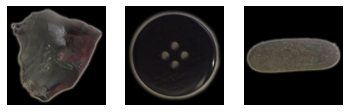

In [6]:
n = len(shadowed)
fig, ax = plt.subplots(1, n, figsize= (2 * n, 2))
for a in ax:
    a.axis("off")
    
for i, pic in enumerate(shadowed):
    ax[i].imshow(pic)

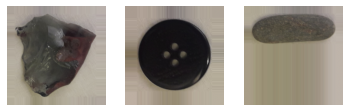

In [7]:
fig, ax = plt.subplots(1, n, figsize= (2 * n, 2))
for a in ax:
    a.axis("off")
    
for i, pic in enumerate(prepared):
    ax[i].imshow(pic)

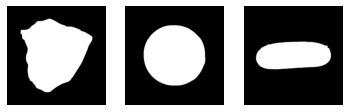

In [8]:
fig, ax = plt.subplots(1, n, figsize= (2 * n, 2))
for a in ax:
    a.axis("off")
    
for i, pic in enumerate(masks):
    ax[i].imshow(pic)

#### Классифицируем 

In [9]:
cl, bb = objr.fit_transform(img)

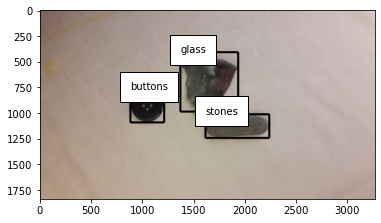

In [10]:
with_bboxes = img.copy()
for b in bb:
    draw_bbox(with_bboxes, b)

plt.imshow(with_bboxes)

for c, b in zip(cl, bb):
    plt.text(b[1], b[0], c, bbox={'facecolor': 'white', 'pad': 10})

#### Для всех объектов заранее заготовлены контуры

In [11]:
import json 
from shapely.geometry import Polygon 
from shapely.affinity import rotate, pi, translate

with open("./IntelligentPlacer/objects_boundary.json", 'r') as f:
    figures = json.load(f)
    objects = {}
    for key, val in figures.items():
        coords = np.array([val['x'], val['y']])
        objects[key] = Polygon((coords.T - np.mean(coords, axis=1)))

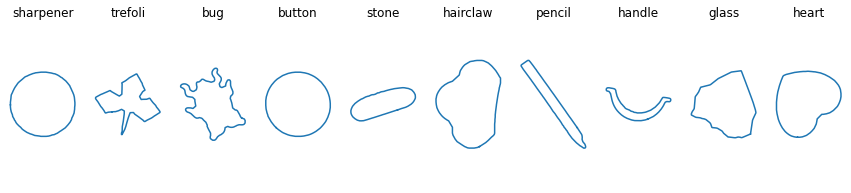

In [12]:
fig, ax = plt.subplots(1, len(objects), figsize=(15, 3))

for i, (name, poly) in enumerate(objects.items()):
    ax[i].axis('off')
    ax[i].axis('equal')
    
    ax[i].plot(*poly.boundary.xy)
    ax[i].set_title(name)


In [13]:
def to_singular(arr):
    arr_o = []
    for a in arr:
        if a != 'glass':
            arr_o.append(a[:-1])
        else:
            arr_o.append(a)
    return arr_o

names = to_singular(cl)
objs = [objects[c] for c in to_singular(cl)]

In [14]:
with open("../data/figures_coordinates.json", 'r') as f:
    figures = json.load(f)
    polygones = {}
    for key, val in figures.items():
        polygones[key] = Polygon(np.array(val))
        
fig = polygones['8']

(-3.832282913595759,
 14.477941185510936,
 -3.6460100677335614,
 15.887905241320645)

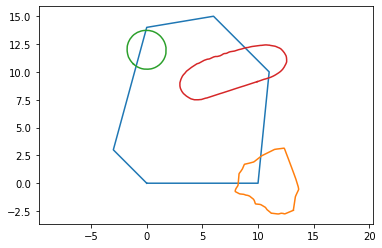

In [15]:
plt.plot(*fig.boundary.xy)
for o in objs:
    plt.plot(*translate(o, np.random.randint(15), np.random.randint(15)).boundary.xy)
plt.axis('equal')
# Есть проблемы с масштабом объектов, они измерялись вручную, чкорее всего ошибка измерения

#### Зададим возможные повороты для объекта, чем более вытянут объект, тем больше поворотов

In [16]:
angles_dict = {"bug": [0, 45, 90, 135]
 , "button" : [0]
 , "glass" : [0]
 , "hairclaw" : [0, 90]
 , "handle" : [0, 45, 90, 135]
 , "heart" : [0, 90]
 , "pencil" : [0, 30, 60, 90, 120, 150]
 , "stone" : [0, 45, 90, 135]
 , "trefoli" : [0, 45]
 , "sharpener" : [0]}

#### Зададим какими могут быть translate и rotation для каждого объекта так, чтобы он не выходил за границу многоугольника


In [17]:
from itertools import product

xs, ys = fig.boundary.xy
xs = np.linspace(min(xs), max(xs), 7) 
ys = np.linspace(min(ys), max(ys), 7)

params = {}
for name in names:
    obj = objects[name]
    angles = angles_dict[name]
    c = [(x, y, a) for x, y, a in product(xs, ys, angles) if fig.contains(translate(rotate(obj, a), x, y))]
    params[name] = c
    
init_config = {
    name : (0, 0, 0) for name in names   
}

#### Найдем возможное расположение объектов 

In [18]:
area, conf = find_min_intersection_configuration(names, objects
                                        , init_config, params
                                        , 100, i_state = 0, intersection_area=0)

#### Отобразим его 

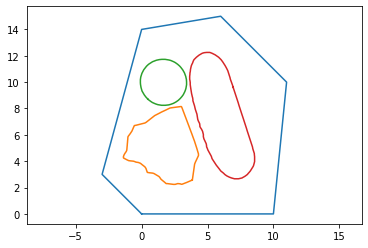

In [19]:
plt.plot(*fig.boundary.xy)

for name, (x, y, a) in conf.items():
    tr_obj = translate(rotate(objects[name], a), x, y)
    plt.plot(*tr_obj.boundary.xy)
    
plt.axis('equal');